In [1]:
!nvidia-smi

Thu May  2 15:45:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000                On | 00000000:61:00.0 Off |                  Off |
| 30%   31C    P8               22W / 300W|      0MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%pwd

'/manitou/pmg/projects/bys2107/gnn-mol'

In [3]:
import math
import operator
from itertools import chain, product
from functools import partial
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict, Sequence, NamedTuple

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

In [4]:
import torch_geometric
from torch_geometric.transforms import BaseTransform, Compose
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

import matplotlib as mpl
import matplotlib.pyplot as plt
# from torch_scatter import scatter

In [5]:
DATA = Path(_dh[-1]) / "data"

/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be

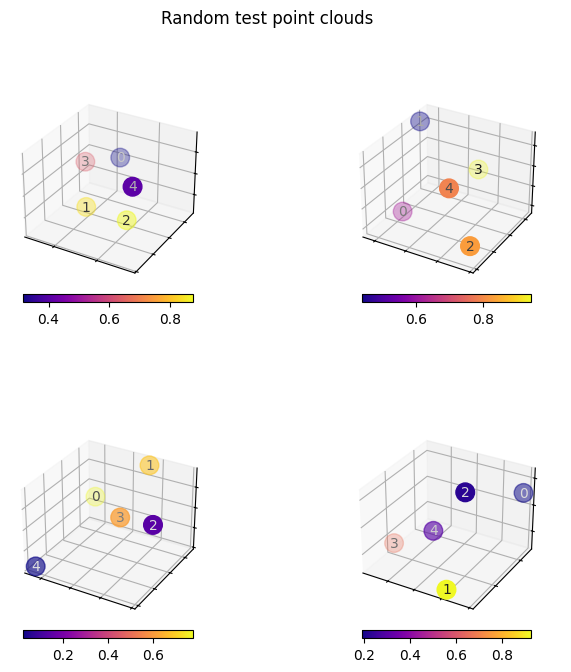

In [6]:
def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1


def plot_point_cloud_3d(
    fig: mpl.figure.Figure,
    ax_pos: int,
    color: np.ndarray,
    pos: np.ndarray,
    cmap: str = "plasma",
    point_size: float = 180.0,
    label_axes: bool = False,
    annotate_points: bool = True,
    remove_axes_ticks: bool = True,
    cbar_label: str = "",
) -> mpl.axis.Axis:
    cmap = mpl.cm.get_cmap(cmap)
    ax = fig.add_subplot(ax_pos, projection="3d")
    x, y, z = pos
    if remove_axes_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
        ax.set_zlabel("$z$ coordinate")
    sc = ax.scatter(x, y, z, c=color, cmap=cmap, s=point_size)
    plt.colorbar(sc, location="bottom", shrink=0.6, anchor=(0.5, 2), label=cbar_label)
    if annotate_points:
        _colors = sc.cmap(color)
        rgb = _colors[:, :3].transpose()
        brightness = to_perceived_brightness(rgb)
        for i, (xi, yi, zi, li) in enumerate(zip(x, y, z, brightness)):
            ax.text(xi, yi, zi, str(i), None, color=[1 - li] * 3, ha="center", va="center")
    return ax


# testing
fig = plt.figure(figsize=(8, 8))

for ax_pos in [221, 222, 223, 224]:
    pos = np.random.rand(3, 5)
    color = np.random.rand(5)
    plot_point_cloud_3d(fig, ax_pos, color, pos)

fig.suptitle("Random test point clouds")
fig.tight_layout()

In [7]:
def plot_model_input(data: Data, fig: mpl.figure.Figure, ax_pos: int) -> mpl.axis.Axis:
    color, pos = data.z, data.pos
    color = color.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atomic number")


def plot_model_embedding(
    data: Data, model: Callable[[Data], Tensor], fig: mpl.figure.Figure, ax_pos: int
) -> mpl.axis.Axis:
    x = model(data)
    pos = data.pos
    color = x.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atom embedding (1D)")

In [8]:
def num_heavy_atoms(qm9_data: Data) -> int:
    return (qm9_data.z != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    data.complete_edge_index = complete_edge_index(data.num_nodes)
    return data


#
dataset = QM9(
    DATA,
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    pre_transform=add_complete_graph_edge_index,
    force_reload=True
)

print(f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}")

Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.


Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 21800


Done!


In [9]:
!du -sh data

501M	data


In [10]:
data = dataset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], complete_edge_index=[2, 20])

In [11]:
data.pos.round(decimals=2)

tensor([[-0.0100,  1.0900,  0.0100],
        [ 0.0000, -0.0100,  0.0000],
        [ 1.0100,  1.4600,  0.0000],
        [-0.5400,  1.4500, -0.8800],
        [-0.5200,  1.4400,  0.9100]])

/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


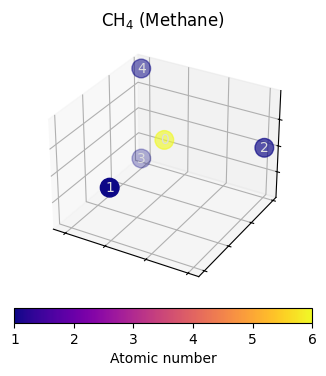

In [12]:
fig = plt.figure()
ax = plot_model_input(data, fig, 111)
_ = ax.set_title("CH$_4$ (Methane)")

In [21]:
data.z

tensor([6, 1, 1, 1, 1])

/burg/home/bys2107/.conda/envs/g-eq/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


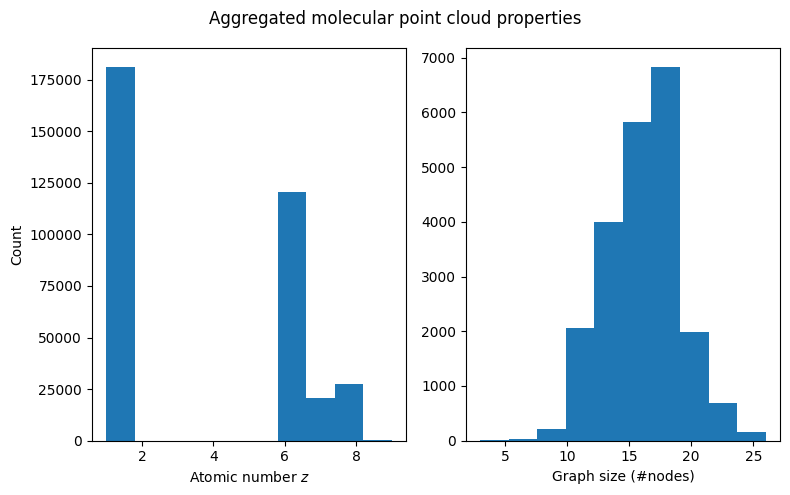

In [13]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8, 5))

ax_atoms.hist(dataset.data.z)
ax_atoms.set_xlabel("Atomic number $z$")
ax_atoms.set_ylabel("Count")
num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
ax_graph_size.hist(num_nodes)
ax_graph_size.set_xlabel("Graph size (#nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

In [16]:
class QM9DataModule:
    def __init__(
        self,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        target_idx: int = 5,
        seed: float = 420,
    ) -> None:
        assert sum([train_ratio, val_ratio, test_ratio]) == 1
        self.target_idx = target_idx
        self.num_examples = len(self.dataset())
        rng = np.random.default_rng(seed)
        self.shuffled_index = rng.permutation(self.num_examples)
        self.train_split = self.shuffled_index[: int(self.num_examples * train_ratio)]
        self.val_split = self.shuffled_index[
            int(self.num_examples * train_ratio) : int(
                self.num_examples * (train_ratio + val_ratio)
            )
        ]
        self.test_split = self.shuffled_index[
            int(self.num_examples * (train_ratio + val_ratio)) : self.num_examples
        ]

    def dataset(self, transform=None) -> QM9:
        dataset = QM9(
            DATA,
            pre_filter=lambda data: num_heavy_atoms(data) < 9,
            pre_transform=add_complete_graph_edge_index,
            # force_reload=True
        )
        dataset.data.y = dataset.data.y[:, self.target_idx].view(-1, 1)
        return dataset

    def loader(self, split, **loader_kwargs) -> DataLoader:
        dataset = self.dataset()[split]
        return DataLoader(dataset, **loader_kwargs)

    def train_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.train_split, shuffle=True, **loader_kwargs)

    def val_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.val_split, shuffle=False, **loader_kwargs)

    def test_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.test_split, shuffle=False, **loader_kwargs)

Text(0.5, 0.98, 'Random data split - target distribution')

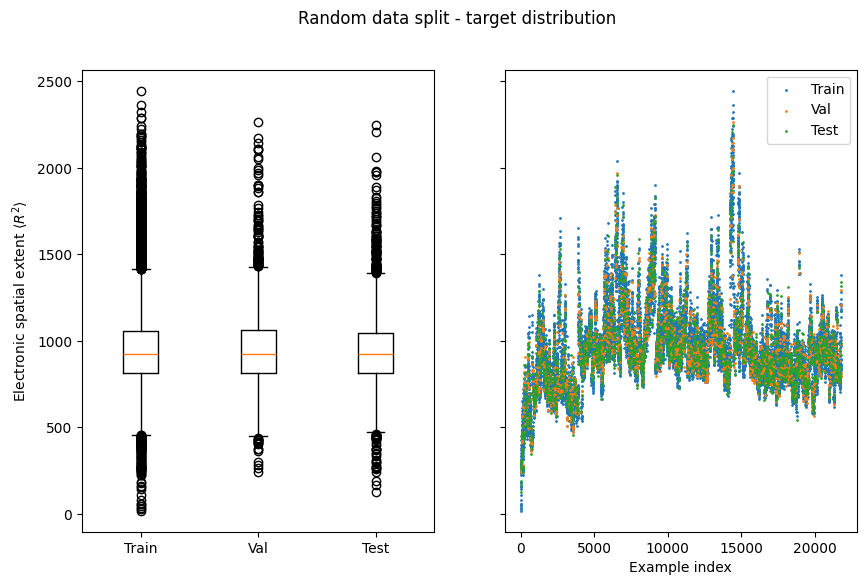

In [17]:
data_module = QM9DataModule()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
target = data_module.dataset().data.y.flatten().numpy()
ax1.boxplot(
    [
        target[data_module.train_split],
        target[data_module.val_split],
        target[data_module.test_split],
    ]
)
ax1.set_xticklabels(["Train", "Val", "Test"])
ax1.set_ylabel("Electronic spatial extent $\langle R^2 \\rangle$")

for label, split in {
    "Train": data_module.train_split,
    "Val": data_module.val_split,
    "Test": data_module.test_split,
}.items():
    ax2.scatter(split, target[split], label=label, s=1)

ax2.set_xlabel("Example index")
ax2.legend()
fig.suptitle("Random data split - target distribution")

In [22]:
class NaiveEuclideanGNN(nn.Module):
    def __init__(self, hidden_channels, num_layers, num_spatial_dims,
                 final_embedding_size = None,
                 act = nn.ReLU()):
        super().__init__()
        # EMBEDDING FOR THE ATOM
        self.f_initial_embed = nn.Embedding(100, hidden_channels)
        # LINEAR LAYER FOR POSITION EMBEDDING
        self.f_pos_embed = nn.Linear(num_spatial_dims, hidden_channels)
        self.f_combine = nn.Sequential(
            nn.Linear(2*hidden_channels, hidden_channels),
            act
        )
        if final_embedding_size is None:
            final_embedding_size = hidden_channels
        self.gnn = geom_nn.models.GIN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=final_embedding_size,
            num_layers=num_layers,
            act=act,
        )
        self.aggregation = geom_nn.aggr.SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            act,
            nn.Linear(final_embedding_size, 1),
        )

    def encode(self, data: Data):
        atom_embedding = self.f_initial_embed(data.z)
        pos_embedding = self.f_pos_embed(data.pos)

        initial_node_embed = self.f_combine(torch.cat((atom_embedding, pos_embedding), dim=-1))

        node_embed = self.gnn(initial_node_embed, data.edge_index)
        return node_embed

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        aggr = self.aggregation(node_embed, data.batch)
        return self.f_predict(aggr)

In [23]:
def rotation_matrix_z(theta: float) -> Tensor:
    return torch.tensor(
        [
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta), math.cos(theta), 0],
            [0, 0, 1],
        ]
    )

/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be

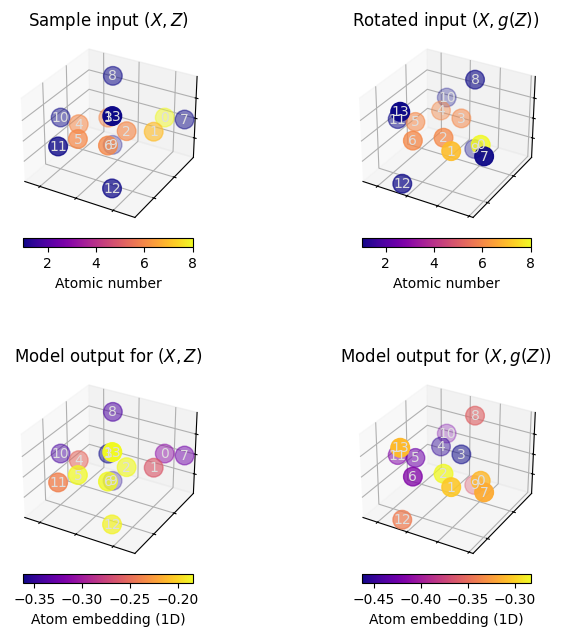

In [24]:
sample_data = dataset[800].clone()

rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(45)

model = NaiveEuclideanGNN(
    hidden_channels=32,
    num_layers=2,
    num_spatial_dims=3,
    final_embedding_size=1,
)

fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

In [25]:
# YOINKED FROM PYTORCH_SCATTER
def scatter(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
            out: Optional[torch.Tensor] = None, dim_size: Optional[int] = None,
            reduce: str = "sum") -> torch.Tensor:
    if reduce == 'sum' or reduce == 'add':
        return scatter_sum(src, index, dim, out, dim_size)
    raise ValueError

def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)

def broadcast(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

In [26]:
src = torch.randn(10, 6, 64)
index = torch.tensor([0, 1, 0, 1, 2, 1])

out = scatter(src, index, dim=1, reduce="sum")

print(out.size())

torch.Size([10, 3, 64])


In [27]:
class EquivariantMPLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        act: nn.Module,
    ) -> None:
        super().__init__()
        self.act = act
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)

        message_input_size = 2 * in_channels + 1

        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
        )
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,
        target_node_embed: Tensor,
        node_dist: Tensor,
    ) -> Tensor:
        message_repr = torch.cat((source_node_embed, target_node_embed, node_dist), dim=-1)
        return self.message_mlp(message_repr)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        rsdist = (xi - xj).pow(2).sum(1, keepdim=True)
        return rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        dist = self.compute_distances(node_pos, edge_index)
        node_messages = self.node_message_function(node_embed[row], node_embed[col], dist)
        aggr_node_messages = scatter(node_messages, col, dim=0, reduce="sum")
        new_node_embed = self.residual_proj(node_embed) + self.node_update_mlp(
            torch.cat((node_embed, aggr_node_messages), dim=-1)
        )

        return new_node_embed


class EquivariantGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        final_embedding_size: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 2,
    ) -> None:
        super().__init__()
        if final_embedding_size is None:
            final_embedding_size = hidden_channels
        self.act = nn.ReLU()
        self.f_initial_embed = nn.Embedding(100, hidden_channels)
        self.message_passing_layers = nn.ModuleList()
        channels = [hidden_channels] * (num_mp_layers) + [final_embedding_size]
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(d_in, d_out, self.act)
            self.message_passing_layers.append(layer)
        self.aggregation = SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            self.act,
            nn.Linear(final_embedding_size, target_size),
        )

    def encode(self, data: Data) -> Tensor:
        node_embed = self.f_initial_embed(data.z)
        for mp_layer in self.message_passing_layers:
            node_embed = mp_layer(node_embed, data.pos, data.complete_edge_index)
        return node_embed

    def _predict(self, node_embed, batch_index) -> Tensor:
        aggr = self.aggregation(node_embed, batch_index)
        return self.f_predict(aggr)

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        pred = self._predict(node_embed, data.batch)
        return pred

In [28]:
model = EquivariantGNN(hidden_channels=32, final_embedding_size=1, num_mp_layers=2)

/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)
/tmp/ipykernel_3660070/441942460.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be

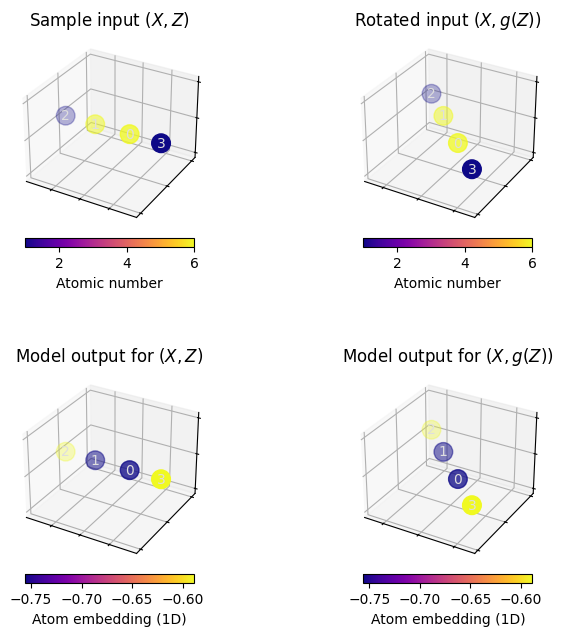

In [32]:
sample_data = dataset[3].clone()

rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(120)

fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

In [33]:
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    return (pred - target).abs().sum(batch_dim)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
):
    def step(
        data_batch: Data,
    ) -> Tuple[float, float]:
        pred = model.forward(data_batch)
        target = data_batch.y
        loss = criterion(pred, target)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        return loss.detach().item(), total_absolute_error(pred.detach(), target.detach())

    if optim is not None:
        model.train()
        model.requires_grad_(True)
    else:
        model.eval()
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader: # iterate over batches
        data.to(device)
        loss, mae = step(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)


def train_model(
    data_module: QM9DataModule,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 32,
    weight_decay: float = 1e-8,
    best_model_path: Path = DATA.joinpath("trained_model.pth"),
) -> Dict[str, Any]:
    # create data loaders
    train_loader = data_module.train_loader(batch_size=batch_size)
    val_loader = data_module.val_loader(batch_size=batch_size)
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-8)
    loss_fn = nn.MSELoss()
    best_val_mae = float("inf")
    result = {
        "model": model,
        "path_to_best_model": best_model_path,
        "train_loss": np.full(num_epochs, float("nan")),
        "val_loss": np.full(num_epochs, float("nan")),
        "train_mae": np.full(num_epochs, float("nan")),
        "val_mae": np.full(num_epochs, float("nan")),
    }
    def update_statistics(i_epoch: int, **kwargs: float):
        for key, value in kwargs.items():
            result[key][i_epoch] = value

    def desc(i_epoch: int) -> str:
        return " | ".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"]
            + [
                f"{key}: {value[i_epoch]:8.2f}"
                for key, value in result.items()
                if isinstance(value, np.ndarray)
            ]
        )

    # main training loop
    for i_epoch in range(0, num_epochs):
        progress_bar = tqdm(total=len(train_loader) + len(val_loader))
        try:
            progress_bar.set_description(desc(i_epoch))
            train_loss, train_mae = run_epoch(model, train_loader, loss_fn, progress_bar, optim)
            val_loss, val_mae = run_epoch(model, val_loader, loss_fn, progress_bar)

            update_statistics(
                i_epoch,
                train_loss=train_loss,
                val_loss=val_loss,
                train_mae=train_mae,
                val_mae=val_mae,
            )

            progress_bar.set_description(desc(i_epoch))

            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            progress_bar.close()

    return result

In [48]:
@torch.no_grad()
def test_model(model: nn.Module, data_module: QM9DataModule) -> Tuple[float, Tensor, Tensor]:
    test_mae = 0
    preds, targets = [], []
    loader = data_module.test_loader()
    for data in loader:
        data.to(device)
        pred = model(data)
        target = data.y
        preds.append(pred)
        targets.append(target)
        test_mae += total_absolute_error(pred, target).item()

    test_mae = test_mae / len(data_module.test_split)

    return test_mae, torch.cat(preds, dim=0), torch.cat(targets, dim=0)

In [49]:
model = EquivariantGNN(hidden_channels=64, num_mp_layers=2)
model.to(device)
model

EquivariantGNN(
  (act): ReLU()
  (f_initial_embed): Embedding(100, 64)
  (message_passing_layers): ModuleList(
    (0-1): 2 x EquivariantMPLayer(
      (act): ReLU()
      (residual_proj): Linear(in_features=64, out_features=64, bias=False)
      (message_mlp): Sequential(
        (0): Linear(in_features=129, out_features=64, bias=True)
        (1): ReLU()
      )
      (node_update_mlp): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
      )
    )
  )
  (aggregation): SumAggregation()
  (f_predict): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [50]:
egnn_train_result = train_model(
    data_module,
    model,
    num_epochs=25,
    lr=2e-4,
    batch_size=32,
    weight_decay=1e-8,
    best_model_path=DATA.joinpath("models/trained_egnn.pth"),
)

Epoch   1 / 25 | train_loss: 80808.00 | val_loss:  7100.32 | train_mae:   168.54 | val_mae:    57.00: 100%|█| 614/614 [0
Epoch   2 / 25 | train_loss:  4613.37 | val_loss:  3844.12 | train_mae:    47.78 | val_mae:    43.35: 100%|█| 614/614 [0
Epoch   3 / 25 | train_loss:  1559.92 | val_loss:   941.81 | train_mae:    27.03 | val_mae:    21.64: 100%|█| 614/614 [0
Epoch   4 / 25 | train_loss:   755.30 | val_loss:   857.48 | train_mae:    18.99 | val_mae:    23.35: 100%|█| 614/614 [0
Epoch   5 / 25 | train_loss:   479.33 | val_loss:   296.93 | train_mae:    15.04 | val_mae:    10.75: 100%|█| 614/614 [0
Epoch   6 / 25 | train_loss:   373.82 | val_loss:   245.66 | train_mae:    13.37 | val_mae:    10.25: 100%|█| 614/614 [0
Epoch   7 / 25 | train_loss:   283.11 | val_loss:   194.09 | train_mae:    11.38 | val_mae:     9.13: 100%|█| 614/614 [0
Epoch   8 / 25 | train_loss:   210.71 | val_loss:   150.45 | train_mae:     9.68 | val_mae:     7.06: 100%|█| 614/614 [0
Epoch   9 / 25 | train_loss:   1

In [52]:
gcn_baseline = NaiveEuclideanGNN(64, 4, 3)
gcn_baseline.to(device)
gcn_train_result = train_model(
    data_module,
    gcn_baseline,
    num_epochs=50,
    lr=2e-4,
    batch_size=32,
    best_model_path=DATA.joinpath("models/trained_gnn.pth"),
)

Epoch   1 / 50 | train_loss: 160827.57 | val_loss: 58994.30 | train_mae:   288.16 | val_mae:   190.95: 100%|█| 614/614 [
Epoch   2 / 50 | train_loss: 51111.90 | val_loss: 42732.43 | train_mae:   168.70 | val_mae:   151.71: 100%|█| 614/614 [0
Epoch   3 / 50 | train_loss: 38484.83 | val_loss: 33023.25 | train_mae:   147.12 | val_mae:   142.97: 100%|█| 614/614 [0
Epoch   4 / 50 | train_loss: 22902.76 | val_loss: 17146.85 | train_mae:   114.23 | val_mae:    96.50: 100%|█| 614/614 [0
Epoch   5 / 50 | train_loss: 14276.77 | val_loss: 12496.95 | train_mae:    89.21 | val_mae:    82.84: 100%|█| 614/614 [0
Epoch   6 / 50 | train_loss: 10680.79 | val_loss: 10685.32 | train_mae:    76.75 | val_mae:    75.31: 100%|█| 614/614 [0
Epoch   7 / 50 | train_loss:  8548.96 | val_loss:  7992.21 | train_mae:    68.21 | val_mae:    64.28: 100%|█| 614/614 [0
Epoch   8 / 50 | train_loss:  7216.45 | val_loss:  7808.35 | train_mae:    62.27 | val_mae:    63.30: 100%|█| 614/614 [0
Epoch   9 / 50 | train_loss:  65

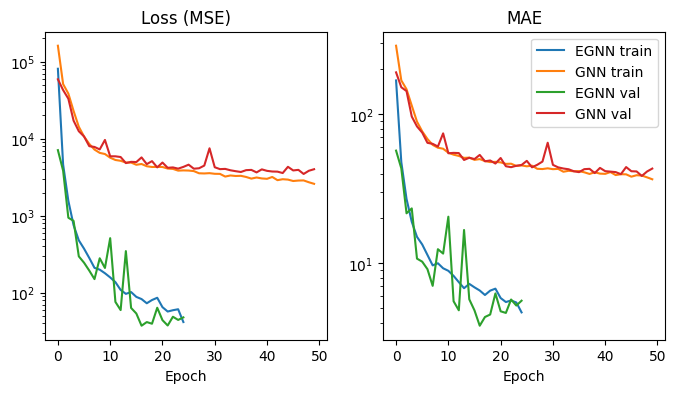

In [54]:
fig, (loss_ax, mae_ax) = plt.subplots(1, 2, figsize=(8, 4))

loss_ax.set_title("Loss (MSE)")
mae_ax.set_title("MAE")
loss_ax.set_xlabel("Epoch")
mae_ax.set_xlabel("Epoch")

for metric in ["train_loss", "val_loss", "train_mae", "val_mae"]:
    split = metric.split("_")[0]
    ax = loss_ax if "loss" in metric else mae_ax

    ax.plot(egnn_train_result[metric], label=f"EGNN {split}")
    ax.plot(gcn_train_result[metric], label=f"GNN {split}")

mae_ax.legend()
mae_ax.set_yscale("log")
loss_ax.set_yscale("log")

In [59]:
!ls

data  e3-eq.ipynb  experiments.ipynb  models
